# 2. Evaluate  Model1 on test data of Dataset B

### downloading datasset

To download Dataset B, we use library that publisher provides

In [1]:
!pip install ftw-tools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Loading of necessary libraries and checking of instance GPU.

In [2]:
import tensorflow as tf
import numpy as np

print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"GPUs detected: {gpus}")
        # Attempt to set memory growth for the first GPU
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Successfully set memory growth for GPU 0.")
    except RuntimeError as e:
        # This might happen if it's somehow already initialized - very unlikely after restart
        print(f"!!! Could not set memory growth (GPU likely already initialized?): {e}")
    except Exception as e:
        print(f"!!! An unexpected error occurred during GPU configuration: {e}")

    # Optional: Verify basic operation AFTER setting memory growth
    try:
         with tf.device('/device:GPU:0'):
             a = tf.constant([[1.0]], dtype=tf.float32)
             b = tf.constant([[2.0]], dtype=tf.float32)
             c = tf.matmul(a, b)
         print("Minimal GPU computation successful after setting memory growth.")
    except Exception as e:
         print(f"!!! Error during minimal GPU computation: {e}")

else:
    print("!!! No GPU detected by TensorFlow.")

TensorFlow Version: 2.18.0
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Successfully set memory growth for GPU 0.
Minimal GPU computation successful after setting memory growth.


### Mount Google Drive

for dowloading pretrained u-net model and install libs for reading tif files

In [3]:
!pip install tifffile imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 51.2 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


download images of Spain

In [5]:
!ftw data download --countries spain


0.000 GB / 0.000 GB [] Speed: 0.00 MB/s
Downloaded /content/data/checksum.md5
Downloaded checksum.md5 to /content/data/checksum.md5
Overall Download Progress:   0% 0/1 [00:00<?, ?country/s]Downloading spain.zip...
1.926 GB / 1.926 GB [] Speed: 14.66 MB/s
Downloaded /content/data/spain.zip
Verifying /content/data/spain.zip...
Checksum verification passed for spain.
Overall Download Progress: 100% 1/1 [02:19<00:00, 139.06s/country]
Created new folder ./data/ftw.
Using 12 CPUs for unpacking.
Unpacking files: 100% 1/1 [00:00<00:00, 16844.59it/s]


In [6]:
# check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import os

# import libs for processing images
import imageio
import imagecodecs
from PIL import Image

# import visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# TF and co
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

Fri May 16 13:42:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             52W /  400W |     437MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [7]:
import os
import tifffile
import numpy as np
import imagecodecs
import rasterio

def LoadAndProcessData(image_dir, mask_dir, mask_channel_index=0, mask_dtype=np.uint8):
    try:
        # List and sort filenames to ensure matching pairs
        image_filenames = sorted(os.listdir(image_dir))
        mask_filenames = sorted(os.listdir(mask_dir))

        # Basic check for equal number of files
        if len(image_filenames) != len(mask_filenames):
            print(f"Warning: Mismatch in file count! Images: {len(image_filenames)}, Masks: {len(mask_filenames)}")

        print(f"Found {len(image_filenames)} potential image/mask pairs.")

        loaded_images = []
        processed_masks = []

        # Iterate through the pairs using zip for safety
        for img_fname, mask_fname in zip(image_filenames, mask_filenames):

            img_base = os.path.splitext(img_fname)[0]
            mask_base = os.path.splitext(mask_fname)[0]

            img_full_path = os.path.join(image_dir, img_fname)
            mask_full_path = os.path.join(mask_dir, mask_fname)

            try:
                with rasterio.open(img_full_path) as src:
                    window_a = src.read()[0:3, :, :]  # reading first 3 bands due to tif format
                    image_data = window_a.transpose(1, 2, 0) / 3000  # normalizing

                # Load semantic and instance data
                with rasterio.open(mask_full_path) as src:
                    semantic_2_class = src.read()

                multi_channel_mask_data = semantic_2_class


                if multi_channel_mask_data.ndim == 3 and multi_channel_mask_data.shape[2] > mask_channel_index:
                    raw_mask = multi_channel_mask_data[:, :, mask_channel_index]
                elif multi_channel_mask_data.ndim == 2 and mask_channel_index == 0:

                    print(f"  Info: Mask '{mask_fname}' is already 2D, using as is.")
                    raw_mask = multi_channel_mask_data
                else:
                    print(f"Error: Mask '{mask_fname}' has unexpected shape {multi_channel_mask_data.shape} or invalid channel index {mask_channel_index}. Skipping pair.")
                    continue # Skip this image/mask pair

                # conv the extracted mask channel to the target integer format
                final_mask = raw_mask.astype(mask_dtype)

                loaded_images.append(image_data)
                processed_masks.append(semantic_2_class[0])

            except FileNotFoundError:
                print(f"Error: File not found for pair. Image: '{img_full_path}', Mask: '{mask_full_path}'. Skipping.")
            except Exception as e:
                print(f"Error processing pair: Image='{img_fname}', Mask='{mask_fname}'. Error: {e}. Skipping.")

    except FileNotFoundError as e:
        print(f"Error: Cannot access directory. Path: {e.filename}")
        return [], []
    except Exception as e:
        print(f"An unexpected error occurred in LoadAndProcessData: {e}")
        return [], []

    print(f"Successfully loaded {len(loaded_images)} image/mask pairs.")
    return loaded_images, processed_masks


In [8]:
import cv2
import numpy as np
from PIL import Image

def PreprocessData(loaded_images, processed_masks, target_shape_img, target_shape_mask):
    m = len(loaded_images)
    if m == 0:
        print("Warning: No images/masks provided.")
        return np.zeros((0, *target_shape_img), dtype=np.float32), np.zeros((0, *target_shape_mask[:2], target_shape_mask[2]), dtype=np.int32)


    i_h, i_w, i_c = target_shape_img
    m_h, m_w, m_c = target_shape_mask

    if m_c != 1:
         print(f"Warning: target_shape_mask expects {m_c} channels, but semantic segmentation usually requires 1.")

    X = np.zeros((m, i_h, i_w, i_c), dtype=np.float32)
    y = np.zeros((m, m_h, m_w, m_c), dtype=np.int32)

    print(f"Preprocessing {m} image/mask pairs...")

    for index, (img_array, mask_array) in enumerate(zip(loaded_images, processed_masks)):
        try:
            # --- Input ---
            print(f"Input index {index}: dtype={img_array.dtype}, shape={img_array.shape}, min={np.min(img_array)}, max={np.max(img_array)}")

            img_array_f32 = img_array.astype(np.float32)

            if img_array_f32.ndim == 2:
                 img_array_f32 = cv2.cvtColor(img_array_f32, cv2.COLOR_GRAY2RGB)
            elif img_array_f32.shape[2] == 1:
                 img_array_f32 = cv2.cvtColor(img_array_f32, cv2.COLOR_GRAY2RGB)

            if img_array_f32.shape[0] != i_h or img_array_f32.shape[1] != i_w:
                 img_resized_array = cv2.resize(img_array_f32, (i_w, i_h), interpolation=cv2.INTER_LINEAR)
            else:
                 img_resized_array = img_array_f32

            # Based on observed max ~2.5. Using 2.5 or slightly higher (e.g., 3.0) as the divisor.
            scale_divisor = 2.5
            scaled_image = img_resized_array / scale_divisor

            scaled_image = np.clip(scaled_image, 0.0, 1.0)


            X[index] = scaled_image

            if mask_array.ndim == 3 and mask_array.shape[2] == 1:
                mask_array = np.squeeze(mask_array, axis=-1)
            if mask_array.ndim != 2:
                 raise ValueError(f"Mask at index {index} has unexpected shape {mask_array.shape} after squeeze.")


            if mask_array.dtype != np.uint8:
                 print(f"Warning: Mask {index} dtype is {mask_array.dtype}. Converting to uint8. Max label: {np.max(mask_array)}")
                 if np.max(mask_array) > 255:
                     print(f"ERROR: Mask {index} has labels > 255, cannot safely convert to uint8 for PIL.")
                     continue
                 mask_array = mask_array.astype(np.uint8)

            pil_mask = Image.fromarray(mask_array)
            # Resize mask using NEAREST
            if pil_mask.size != (m_w, m_h):
                 pil_mask_resized = pil_mask.resize((m_w, m_h), Image.Resampling.NEAREST)
            else:
                 pil_mask_resized = pil_mask

            mask_resized_array = np.array(pil_mask_resized) #

            y[index] = np.expand_dims(mask_resized_array, axis=-1).astype(np.int32)

        except Exception as e:
            print(f"Error processing data at index {index}: {e}")

            X[index] = 0
            y[index] = -1


    print("Finished preprocessing.")

    return X, y

### Load data

Loading data using LoadAndProcessData...
Found 2432 potential image/mask pairs.


Successfully loaded 2432 image/mask pairs.

Displaying 5 example(s):

Image 0:
  Shape: (256, 256, 3), dtype: float64
Mask 0:
  Shape: (256, 256), dtype: uint8
  Unique mask values: [0 1]


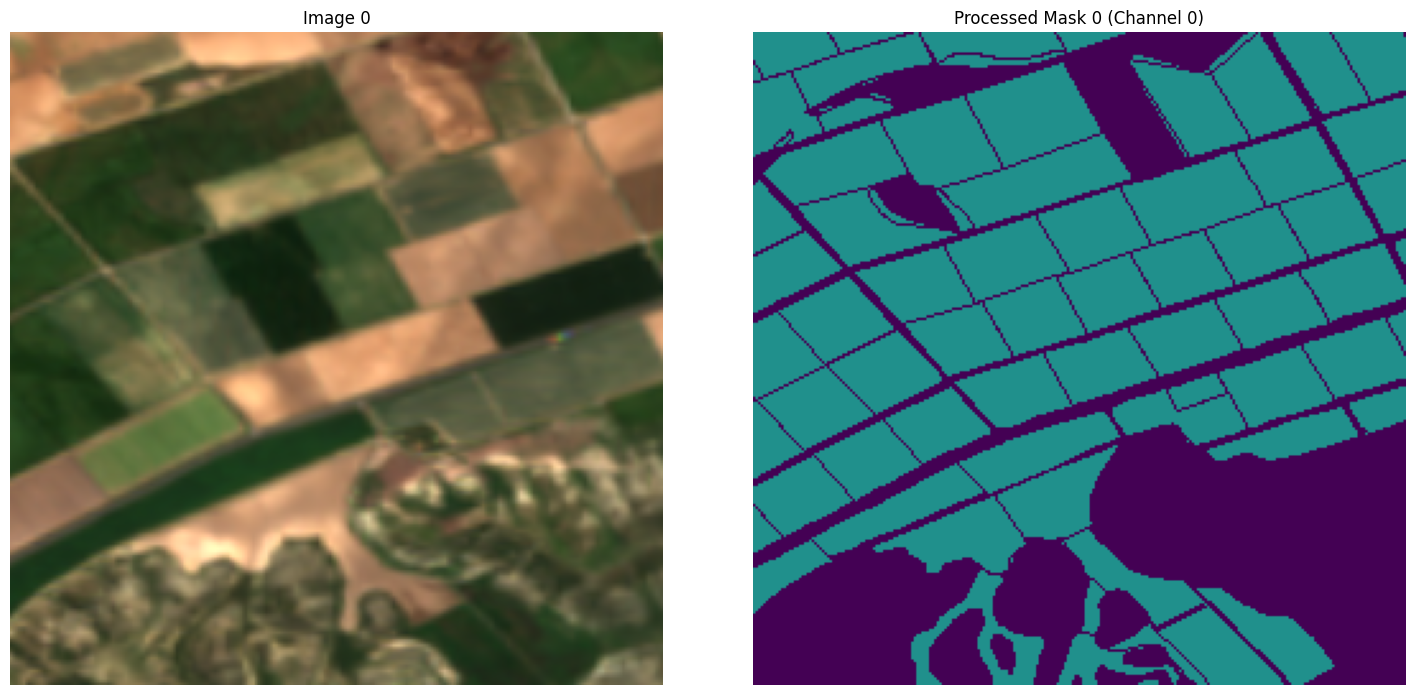


Image 1:
  Shape: (256, 256, 3), dtype: float64
Mask 1:
  Shape: (256, 256), dtype: uint8
  Unique mask values: [0 1]


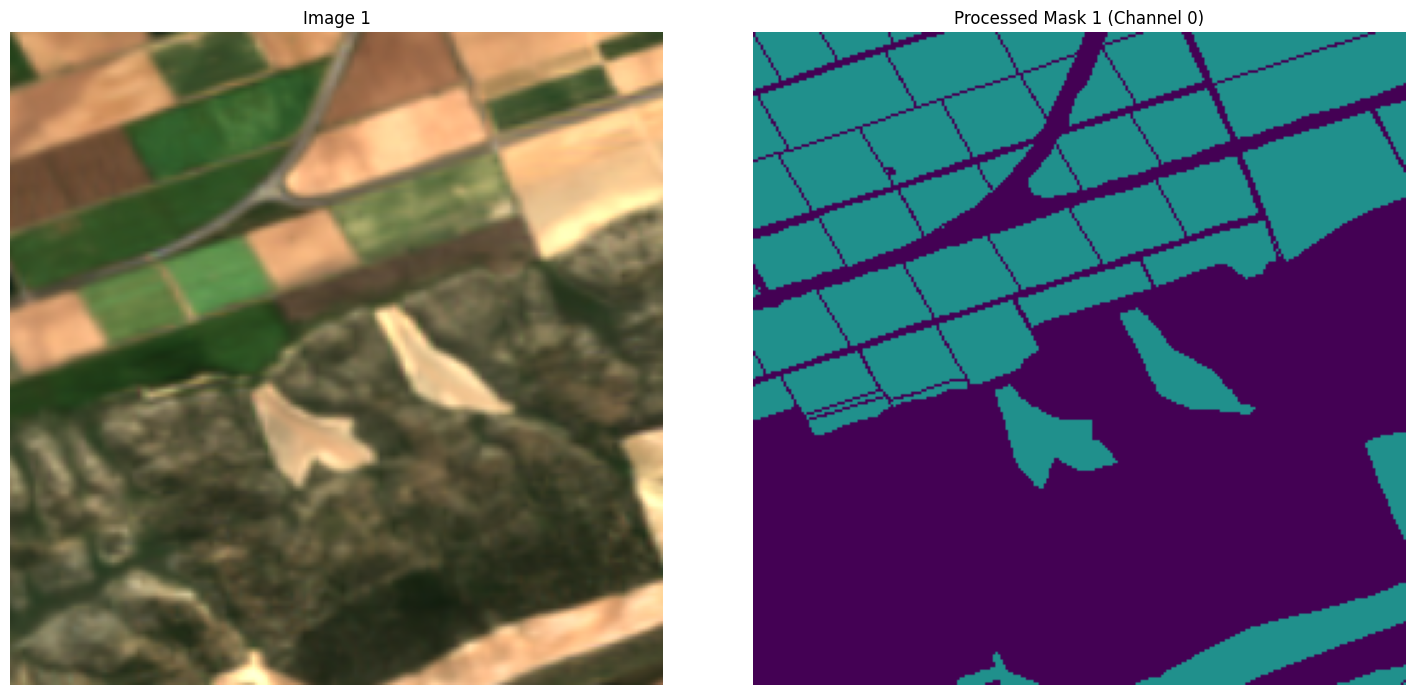


Image 2:
  Shape: (256, 256, 3), dtype: float64
Mask 2:
  Shape: (256, 256), dtype: uint8
  Unique mask values: [0 1]


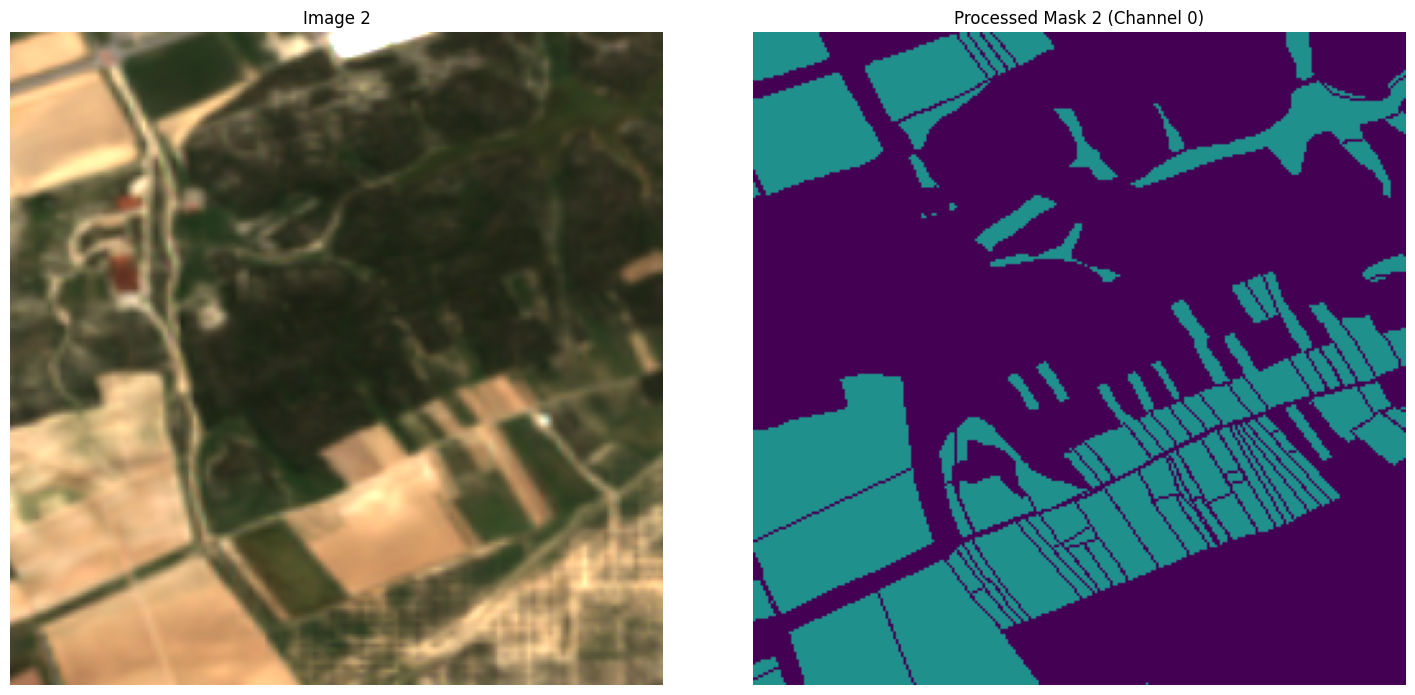


Image 3:
  Shape: (256, 256, 3), dtype: float64
Mask 3:
  Shape: (256, 256), dtype: uint8
  Unique mask values: [0 1]


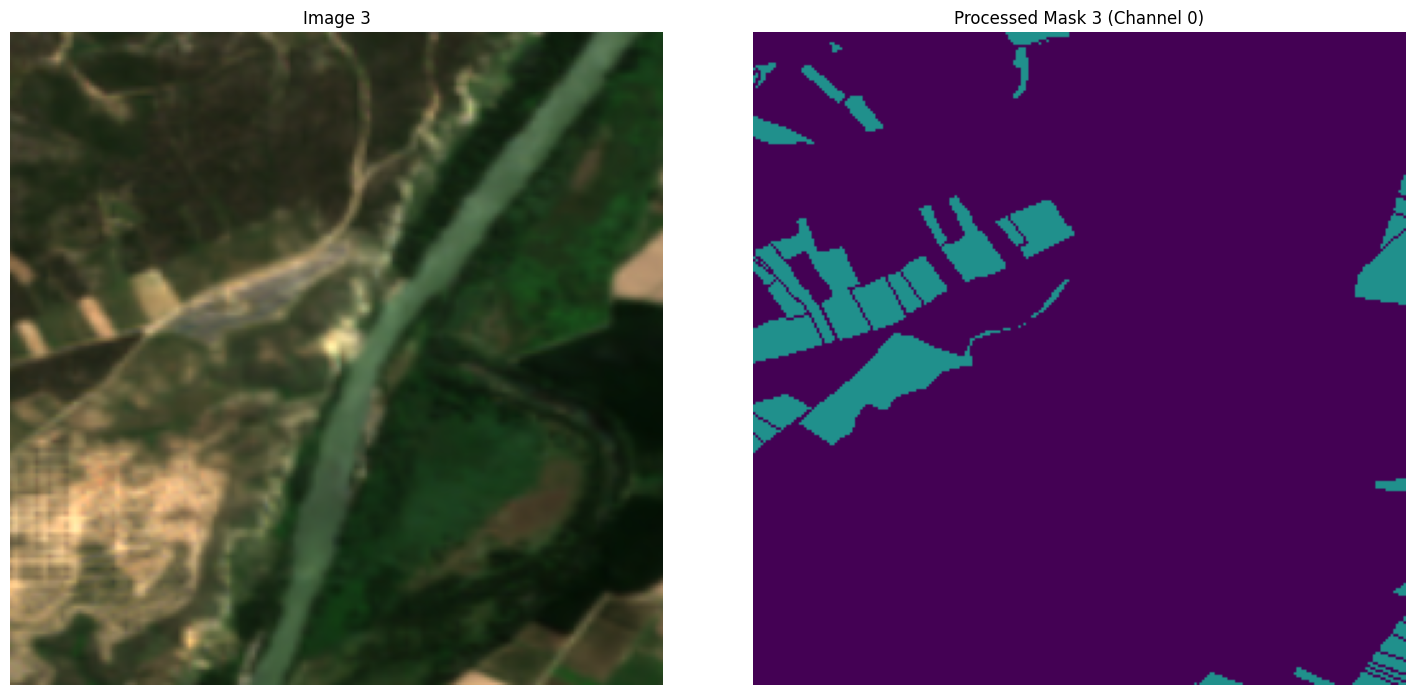


Image 4:
  Shape: (256, 256, 3), dtype: float64
Mask 4:
  Shape: (256, 256), dtype: uint8
  Unique mask values: [0 1]


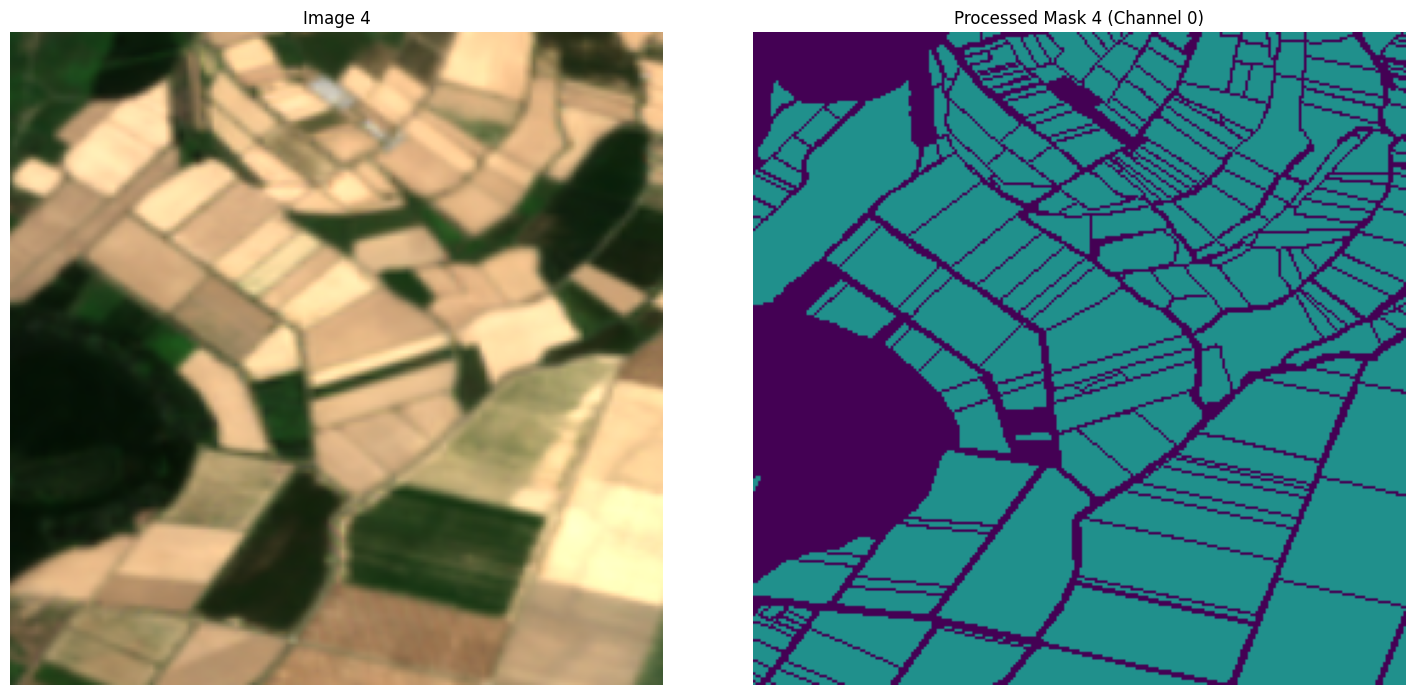

In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import imagecodecs


IMAGE_TRAIN_PATH = './data/ftw/spain/s2_images/window_b' #it has pair of images per mask that shows differnt condition. we take window b that shows no weather conditions.
MASK_TRAIN_PATH = './data/ftw/spain/label_masks/semantic_2class/'

if os.path.exists(IMAGE_TRAIN_PATH) and os.path.exists(MASK_TRAIN_PATH):
    print("Loading data using LoadAndProcessData...")

    img, mask = LoadAndProcessData(IMAGE_TRAIN_PATH, MASK_TRAIN_PATH, mask_channel_index=0, mask_dtype=np.uint8)
else:
    print(f"Error: Training directories not found at '{IMAGE_TRAIN_PATH}' or '{MASK_TRAIN_PATH}'")
    img, mask = [], []


if img and mask:

    show_images = min(5, len(img))
    print(f"\nDisplaying {show_images} example(s):")
    for i in range(show_images):

        img_view = img[i]
        mask_view = mask[i]

        print(f"\nImage {i}:")
        print(f"  Shape: {img_view.shape}, dtype: {img_view.dtype}")
        print(f"Mask {i}:")
        print(f"  Shape: {mask_view.shape}, dtype: {mask_view.dtype}")
        print(f"  Unique mask values: {np.unique(mask_view)}")

        fig, arr = plt.subplots(1, 2, figsize=(15, 7)) # Adjusted figsize for better layout

        # image
        arr[0].imshow(img_view)
        arr[0].set_title(f'Image {i}')
        arr[0].axis('off') # Hide axes ticks

        # mask
        arr[1].imshow(mask_view, cmap='viridis',vmin=0, vmax=2)

        arr[1].set_title(f'Processed Mask {i} (Channel 0)')
        arr[1].axis('off')

        plt.tight_layout()
        plt.show()
else:
    print("\nNo data loaded, skipping display.")

### Prepare train dataset and resize

Preprocessing 2432 image/mask pairs...
Input index 0: dtype=float64, shape=(256, 256, 3), min=0.049, max=1.2576666666666667
Input index 1: dtype=float64, shape=(256, 256, 3), min=0.058, max=1.3863333333333334
Input index 2: dtype=float64, shape=(256, 256, 3), min=0.06566666666666666, max=2.3
Input index 3: dtype=float64, shape=(256, 256, 3), min=0.013, max=1.1616666666666666
Input index 4: dtype=float64, shape=(256, 256, 3), min=0.013333333333333334, max=1.2616666666666667
Input index 5: dtype=float64, shape=(256, 256, 3), min=0.03933333333333333, max=1.1933333333333334
Input index 6: dtype=float64, shape=(256, 256, 3), min=0.05, max=1.092
Input index 7: dtype=float64, shape=(256, 256, 3), min=0.05, max=1.2086666666666666
Input index 8: dtype=float64, shape=(256, 256, 3), min=0.05566666666666667, max=1.3856666666666666
Input index 9: dtype=float64, shape=(256, 256, 3), min=0.04833333333333333, max=1.4506666666666668
Input index 10: dtype=float64, shape=(256, 256, 3), min=0.075333333333

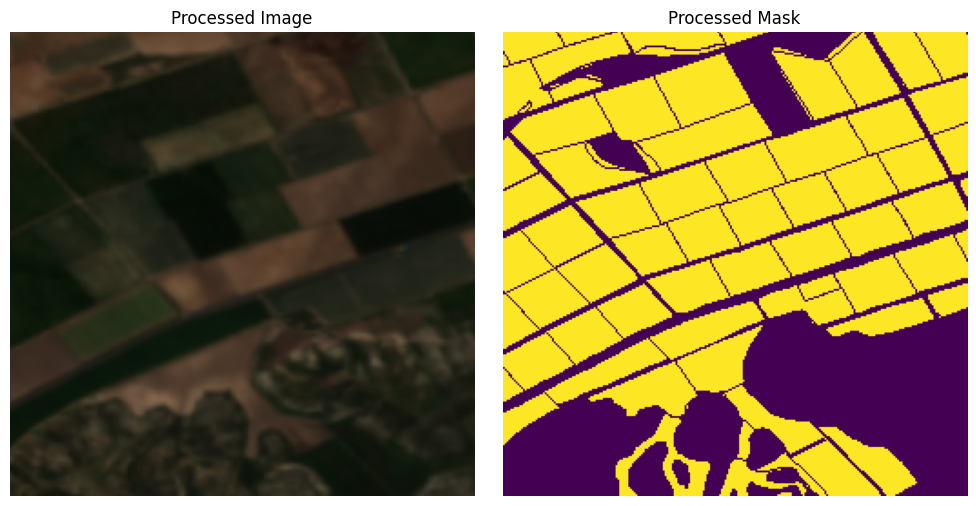

In [11]:

target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]


if 'img' in locals() and 'mask' in locals() and img and mask: #

    X_train, y_train = PreprocessData(img, mask, target_shape_img, target_shape_mask)

    if X_train.size > 0 and y_train.size > 0 :
        total_pixels = y_train.size
        unique_classes, counts = np.unique(y_train, return_counts=True)
        print("\nClass distribution in y_train (after resizing):")
        for cls, count in zip(unique_classes, counts):
            percentage = (count / total_pixels) * 100
            print(f"  Class {cls}: {count} pixels ({percentage:.2f}%)")


        print("\nProcessed Shapes:")
        print("X_train Shape:", X_train.shape)
        print("y_train shape:", y_train.shape)

        image_index = 0
        print(f"\nVisualizing processed example index {image_index}:")
        fig, arr = plt.subplots(1, 2, figsize=(10, 5))

        print(f"Data type: {X_train[image_index].dtype}")
        print(f"Shape: {X_train[image_index].shape}")
        print(f"Min value: {np.min(X_train[image_index])}")
        print(f"Max value: {np.max(X_train[image_index])}")
        print(f"Mean value: {np.mean(X_train[image_index])}")

        arr[0].imshow(X_train[image_index])
        arr[0].set_title('Processed Image')
        arr[0].axis('off')

        # mask
        arr[1].imshow(np.squeeze(y_train[image_index]), cmap='viridis')
        arr[1].set_title('Processed Mask')
        arr[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("\nPreprocessing resulted in empty arrays.")
else:
    print("\nVariables 'img' and 'mask' not found or are empty.")

### Ensure masks are correct

In [12]:
print(np.unique(y_train))

[0 1]


### Load model

download pretrained model


In [35]:

!cp ./drive/MyDrive/dissertation/unet_basic_v1_256.keras ./unet_basic_v1_256.keras

In [45]:
class SegF1(tf.keras.metrics.Metric):
    def __init__(self, name="macro_f1", **kw):
        super().__init__(name=name, **kw)
        self.f1 = tf.keras.metrics.F1Score(average="macro", threshold=None)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # flatten to (N,) then expand to (N,1) → now 2-D
        y_true = tf.reshape(y_true, [-1, 1])
        y_pred = tf.reshape(tf.argmax(y_pred, -1), [-1, 1])
        self.f1.update_state(y_true, y_pred, sample_weight)

    def result(self):       return self.f1.result()
    def reset_states(self): self.f1.reset_states()

In [46]:


unetv1 = tf.keras.models.load_model('./unet_basic_v1_256.keras', custom_objects={"SegF1": SegF1})
print("loaded model")

loaded model


## Evaluating model on Dataset B

We use publisher lib to load data, and it installed wrong CUDA packages. As result using of GPU was broken I have managed to run evaluation only on CPU.

In [50]:
# Cell 6: Evaluate (CPU) - Corrected Version
if 'X_train' in locals() and 'y_train' in locals():
    print("Starting CPU evaluation...")
    try:
        # Force operations AND variable placement onto CPU
        with tf.device('/device:CPU:0'):
            print("Loading model onto CPU...")
            # Load the model INSIDE the CPU context
            unetv1_cpu = tf.keras.models.load_model('./unet_basic_v1_256.keras', custom_objects={"SegF1": SegF1})
            print("Model loaded onto CPU. Starting evaluation...")
            # Evaluate using the CPU-loaded model
            results_cpu = unetv1_cpu.evaluate(X_train, y_train, batch_size=16, verbose=1)
            print("\nCPU Evaluation Results:", results_cpu)
            print("CPU evaluation completed without runtime errors.")
    except Exception as e:
        print("\n!!! Error during CPU evaluation:")
        print(e) # Note any errors here
else:
    print("Data not loaded, skipping CPU evaluation.")

Starting CPU evaluation...
Loading model onto CPU...
Model loaded onto CPU. Starting evaluation...
152/152 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.4515 - crop_iou: 0.1809 - loss: 1.2696 - macro_f1: 0.3057

CPU Evaluation Results: [1.1793988943099976, 0.5151708722114563, 0.15262381732463837, 0.2648284435272217]
CPU evaluation completed without runtime errors.


### Results
As we see model show poor performance

Let's visualize segmentation results

In [51]:
# Results of Validation Dataset
def VisualizeResults(index):
  with tf.device('/device:CPU:0'):
    img = X_train[index]
    img = img[np.newaxis, ...]
    pred_y = unetv1_cpu.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_train[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_train[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


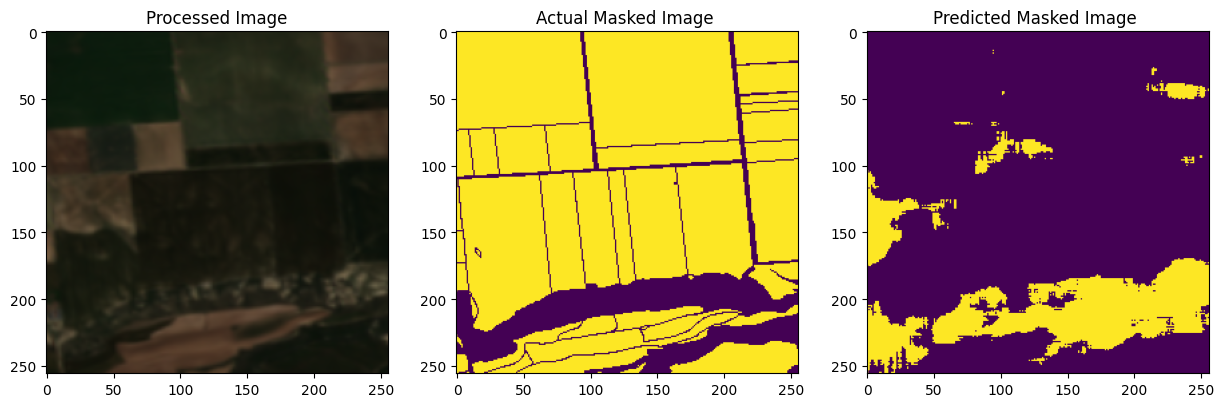

In [52]:
index = 10
VisualizeResults(index)